In [1]:
%matplotlib notebook
import numpy as np
import tensorflow as tf
import matplotlib.pylab as plt
from shutil import move
import os
import helpfuns as hf
from util import *
import sounddevice as sd
import scipy.io.wavfile as wavf
from math import floor

Data importing

In [2]:
# Default parameters for data loading
DEFAULT_SHUFFLE = True
DATASET_SIZE = 23666
EPOCHS = 1
signal_size = 16384

In [3]:
# Directory paths for data loading
tr_data_dir = '../data/SC09_Preprocessed/'

In [4]:
def get_file_list(file_dir):
    file_list = []
    for file in os.listdir(file_dir):
        if(file.endswith('.tfrecords')):
            file_list.append(file_dir + file)
    return file_list

In [5]:
def save_and_map(file_name):
    reader = tf.TFRecordReader()
    filename_queue = tf.train.string_input_producer([file_name])
    _, example_proto = reader.read(filename_queue)
    reader.reset()
    
    features = {
        'signal' : tf.FixedLenSequenceFeature([1], tf.string, allow_missing = True),
        'label': tf.FixedLenSequenceFeature([], tf.string, allow_missing = True)
    }

    example = tf.parse_single_example(example_proto, features)

    signal = tf.decode_raw(example['signal'], tf.float32)
    label = tf.reduce_join(example['label'], 0)
    
    return signal, label

def signal_properties(signal):
    """To be implemented"""
    return signal[0].get_shape().as_list()[-1]

def placeholder_factory():
    placeholders = {}
#     signal_size = signal_properties(signal)
    placeholders['True_Signal'] = tf.placeholder(tf.float32,
                                           shape=[batch_size, signal_size, 1],
                                           name='True_Signal')
    placeholders['Fake_Signal'] = tf.placeholder(tf.float32,
                                           shape=[batch_size, input_dim],
                                           name='Fake_Signal')
    placeholders['output'] = lambda: tf.placeholder(tf.int16, shape=(None, 1))
    placeholders['is_training']= tf.placeholder(tf.bool, name="is_training")
    return placeholders


Define Models

In [6]:
   
def PhaseShuffle(net, scope=None):
    """randomly perturbs the phase of each layer’s activations 
    by −2 to 2 samples before input to the next layer. 
    We use reflection padding to fill in the the missing samples"""
    rand_phase = tf.random_uniform([], 
                              minval=-2, 
                              maxval=2 + 1, 
                              dtype=tf.int32,
                              name="rand_sampling")
    pading_scheme = [[0, 0], [ tf.maximum(rand_phase, 0), tf.maximum(-rand_phase, 0)], [0, 0]]
    org_dims = net.get_shape().as_list()
    net = tf.pad(net,
                 paddings=pading_scheme,
                 mode='REFLECT',
                 name="refl_pading")[:, tf.maximum(-rand_phase, 0):tf.maximum(-rand_phase, 0)+org_dims[1]]
    net.set_shape(org_dims)
    net = tf.identity(net, name=scope+"_PhaseShuffle")
    return net

# Deconvolution Opperation
def conv1d_transpose(inputs,filters,kernel_width=25,stride=4,activation=tf.nn.relu,\
                     weight_initializer=None,batchnorm=False,is_training=True,scope=None):
    
    net = tf.layers.conv2d_transpose(
        tf.expand_dims(inputs, axis=1),
        filters=filters,
        kernel_size=(1, kernel_width),
        strides=(1, stride),
        padding='SAME',
        activation=None,
        kernel_initializer=weight_initializer,
        name=scope+"_conv1d")[:, 0]


    if batchnorm:
        net = tf.layers.batch_normalization(net, training=is_training, fused=True, name=scope+"_BN")
        net = activation(net, name=scope+"_act")
    else:
        net = activation(net, name=scope+"_actv")
    return net

def add_special_layers(net,scope=None, is_training=True, batchnorm=True, activation=None, shuffle=True):
    if shuffle:
        net = PhaseShuffle(net, scope=scope)
    if batchnorm:
        net = tf.layers.batch_normalization(net, training=is_training, fused=True, name=scope+"_BN")
    if activation != None:
        net = activation(net, name=scope+"_actv")
    return net

In [7]:
def generator(placeholders, add_filer=False):
    with tf.variable_scope('Generator'):
            weight_initializer = tf.glorot_uniform_initializer()
            is_training = placeholders['is_training']
            
            net = placeholders['Fake_Signal']
            net = tf.identity(net, name="Generator_INPUT")
            net = tf.layers.dense(net,
                                  units=16384,
                                  kernel_initializer=None,
                                  name="fc1")
            net = tf.layers.batch_normalization(net, training=is_training, fused=True, name="fc1_BN")
            net = tf.nn.relu(net, name="fc1_ReLu")
            net = tf.reshape(net, [batch_size, 16, 1024], name="fc1_rs")
            
#            UNCOMMENT TO TEST LOW MEMORY GPUs (and comment the others)
#             net = tf.layers.dense(placeholders['Fake_Signal'],
#                       units=2,
#                       kernel_initializer=None,
#                       name="fake1")
#             net = tf.layers.dense(net,
#                                   units=16384,
#                                   kernel_initializer=None,
#                                   name="fake2")
#             net=tf.expand_dims(net, axis=2)
            

            net = conv1d_transpose(net,
                                   filters=512,
                                   kernel_width=25,
                                   stride=4, 
                                   batchnorm = True,
                                   weight_initializer=weight_initializer,
                                   is_training=placeholders['is_training'],
                                   scope="tc1")
            net = conv1d_transpose(net,
                                   filters=256,
                                   kernel_width=25,
                                   stride=4, 
                                   batchnorm = True,
                                   weight_initializer=weight_initializer,
                                   is_training=placeholders['is_training'],
                                   activation=tf.nn.relu,
                                   scope="tc2")
            net = conv1d_transpose(net,
                                   filters=128,
                                   kernel_width=25,
                                   stride=4, 
                                   batchnorm = True,
                                   activation=tf.nn.relu,
                                   weight_initializer=weight_initializer,
                                   is_training=placeholders['is_training'],
                                   scope="tc3")
            net = conv1d_transpose(net,
                                   filters=64,
                                   kernel_width=25,
                                   stride=4, 
                                   batchnorm = True,
                                   activation=tf.nn.relu,
                                   weight_initializer=weight_initializer,
                                   is_training=placeholders['is_training'],
                                   scope="tc4")
            net = conv1d_transpose(net,
                                   filters=1,
                                   kernel_width=25,
                                   stride=4, 
                                   batchnorm = True,
                                   activation=tf.nn.tanh,
                                   weight_initializer=weight_initializer,
                                   is_training=placeholders['is_training'],
                                   scope="tc5")  
            
            if add_filer:
                net = tf.layers.conv1d(net, 
                                       filters=1, 
                                       kernel_size=512, 
                                       use_bias=False, 
                                       padding='SAME',
                                       kernel_initializer=weight_initializer,
                                      name="add_G_filer")
                
            update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
            with tf.control_dependencies(update_ops):
                net = tf.identity(net, name="Generator_OUTPUT")
                
            return net

def discriminator(inputs, is_training=True):
    with tf.variable_scope('Discriminator'):
        weight_initializer = tf.glorot_uniform_initializer()
        
        net = tf.layers.conv1d(inputs,
                               filters=64, 
                               kernel_size=25, 
                               strides=4, 
                               padding='SAME',
                               kernel_initializer=weight_initializer,
                               name="conv1")
        net = add_special_layers(net, 
                                 scope="conv1", 
                                 is_training=is_training, 
                                 batchnorm=True, 
                                 activation=tf.nn.leaky_relu, 
                                 shuffle=True)
        net = tf.layers.conv1d(net,
                               filters=128, 
                               kernel_size=25, 
                               strides=4, 
                               padding='SAME',
                               kernel_initializer=weight_initializer,
                               name="conv2")
        net = add_special_layers(net, 
                                 scope="conv2", 
                                 is_training=is_training, 
                                 batchnorm=True, 
                                 activation=tf.nn.leaky_relu, 
                                 shuffle=True)
        net = tf.layers.conv1d(net,
                               filters=256, 
                               kernel_size=25, 
                               strides=4, 
                               padding='SAME',
                               kernel_initializer=weight_initializer,
                               name="conv3")
        net = add_special_layers(net, 
                                 scope="conv3", 
                                 is_training=is_training, 
                                 batchnorm=True, 
                                 activation=tf.nn.leaky_relu, 
                                 shuffle=True)
        net = tf.layers.conv1d(net,
                               filters=512, 
                               kernel_size=25, 
                               strides=4, 
                               padding='SAME',
                               kernel_initializer=weight_initializer,
                               name="conv4")
        net = add_special_layers(net, 
                                 scope="conv4", 
                                 is_training=is_training, 
                                 batchnorm=True, 
                                 activation=tf.nn.leaky_relu, 
                                 shuffle=True)
        net = tf.layers.conv1d(net,
                               filters=1024, 
                               kernel_size=25, 
                               strides=4, 
                               padding='SAME',
                               kernel_initializer=weight_initializer,
                               name="conv5")
        net = add_special_layers(net, 
                                 scope="conv5", 
                                 is_training=is_training, 
                                 batchnorm=True, 
                                 activation=tf.nn.leaky_relu, 
                                 shuffle=False)
        net = tf.layers.flatten(net,name="flatten")
        net = tf.layers.dense(net, 
                              units=1,
                              kernel_initializer=weight_initializer,
                              name="fc_out")[:, 0]
        net = tf.identity(net, name="Discriminator_OUTPUT")
        
        return net

Define Gan Graph

In [8]:
def create_model_graph(graph,sess,placeholders):
    # Get Generator
    Generator_model = generator(placeholders, add_filer=False)
    G_train_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='Generator')
    # Get Real Discriminator
    with tf.name_scope('Real_D'), tf.variable_scope('D_train_vars'):
        Real_D_model = discriminator(placeholders['True_Signal'], is_training=True)
    D_train_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='D_train_vars')
    # Get Fake Discriminator with resue
    with tf.name_scope('Fake_D'), tf.variable_scope('D_train_vars', reuse=True):
        Fake_D_model = discriminator(Generator_model, is_training=True)
        
    # Define loss connectivity (Used opt settings as in the paper)
    Generator_loss = -tf.reduce_mean(Fake_D_model)
    Discriminator_loss = tf.reduce_mean(Fake_D_model) - tf.reduce_mean(Real_D_model)

    alpha = tf.random_uniform(shape=[batch_size, 1, 1], minval=0., maxval=1.)
    differences = Generator_model - placeholders['True_Signal']
    interpolate = placeholders['True_Signal'] + (alpha * differences)
    with tf.name_scope('Interpolator'), tf.variable_scope('D_train_vars', reuse=True):
        D_interpolator = discriminator(interpolate, is_training=True)

    LAMBDA = 10
    gradients = tf.gradients(D_interpolator, [interpolate])[0]
    slopes = tf.sqrt(tf.reduce_sum(tf.square(gradients), reduction_indices=[1, 2]))
    gradient_penalty = tf.reduce_mean((slopes - 1.) ** 2.)
    Discriminator_loss += LAMBDA * gradient_penalty
    
    # Define Optimizers
    G_opt= tf.train.AdamOptimizer(1e-4, beta1=0.5,beta2=0.9).minimize(Generator_loss, 
                                                    var_list=G_train_vars, 
                                                    global_step=tf.train.get_or_create_global_step())
    D_opt= tf.train.AdamOptimizer(1e-4, beta1=0.5,beta2=0.9).minimize(Discriminator_loss, 
                                                    var_list=D_train_vars)

#     G_opt= tf.train.RMSPropOptimizer(5e-5).minimize(Generator_loss, 
#                                                     var_list=G_train_vars, 
#                                                     global_step=tf.train.get_or_create_global_step())
#     D_opt= tf.train.RMSPropOptimizer(5e-5).minimize(Discriminator_loss, 
#                                                     var_list=D_train_vars)
    
    return Generator_model, Generator_loss, Discriminator_loss, G_opt, D_opt

Training Session

In [ ]:
# To be changed!
epochs= 25
batch_size = 12
runs_per_epoch = floor(DATASET_SIZE/batch_size)
input_dim = 100
fs = 16384
rand_sampling = 5
saver_name = "Full_Model"
pretrained_model = None #"Full_Model_it11000"

D_number_of_updates = 5
G_number_of_updates = 1

graph = tf.Graph()
with graph.as_default():
    # Create queue coordinator
    coord = tf.train.Coordinator()

    
    filename_list = get_file_list(tr_data_dir)
    filename_tensors = tf.convert_to_tensor(filename_list, dtype=tf.string)
    input_queue = tf.train.slice_input_producer([filename_tensors], shuffle = True)
    mapped_signal, mapped_label = save_and_map(input_queue[0])
    mapped_signal.set_shape([1, 1, signal_size])
    mapped_label.set_shape([])
    X, Y = tf.train.batch([mapped_signal, mapped_label], batch_size)


    # Get one shot iterator to iterate over mini-batches
    #xs = dataset.make_one_shot_iterator().get_next() 

    
    config = tf.ConfigProto(allow_soft_placement = True)
    config.gpu_options.allow_growth = True


    with tf.Session(config=config, graph=graph) as sess: 
        # create placeholders
        placeholders = placeholder_factory()
        # create model's graph
        Generator_model, Generator_loss, Discriminator_loss, G_opt, D_opt = \
                                            create_model_graph(graph, sess, placeholders)
        # create savers
        saver = tf.train.Saver()
        save_path = get_checkpoint_path(saver_name)
        
        # initialize vars
        sess.run(tf.global_variables_initializer())
        # if pretraned model exists load it
        if pretrained_model != None:
            saver.restore(sess, get_checkpoint_path(pretrained_model))
            restore_live_data = load_pickle_file(get_par_results_path(pretrained_model+"_live_loss.pickle"))
            G_loss_list = restore_live_data["Generator_loss"]
            D_loss_list = restore_live_data["Discriminator_loss"]
            print("Pretrained model successfully restored!")
            ticks = int(pretrained_model.split("it")[1])+1
        else:
            G_loss_list = []
            D_loss_list = []
            ticks = 1
        
        # Start queue threads
        threads = tf.train.start_queue_runners(coord=coord, sess=sess)
        
        # initialize live plot
        fig = plt.figure()
        ax = fig.add_subplot(111)
        plt.ion()
        fig.show()
        fig.canvas.draw()
        
        draw_ref = True
        # initialize training
        for epoch in range(epochs):
            for i in range(runs_per_epoch):
                Fake_Signal = np.random.uniform(low=-1.0, high=1.0, size=[batch_size,input_dim])
                
                batch_data = sess.run(X)
                Real_data=np.expand_dims(np.squeeze(batch_data), axis=2)
                
                # create ref data
                if draw_ref:
                    for k, refs in enumerate(Real_data):
                        ref_path = get_par_results_path("true_sample{}.wav".format(k))
                        wavf.write(ref_path, fs, refs)
                draw_ref = False
                
                fed_dict = {
                    placeholders['True_Signal']: Real_data,
                    placeholders['Fake_Signal']: Fake_Signal,
                    placeholders['is_training']: True
                }
                for iters in range(D_number_of_updates):
                    D_loss, _ = sess.run([Discriminator_loss, D_opt], feed_dict=fed_dict)
                for iters in range(G_number_of_updates):   
                    G_out, G_loss,_ = sess.run([Generator_model, Generator_loss, G_opt], feed_dict=fed_dict)
                
                G_loss_list.append(G_loss)
                D_loss_list.append(D_loss)
#               # Plot Live Evolution
                ax.clear()
                ax.plot(G_loss_list, label='Generator Loss')
                ax.plot(D_loss_list, label='Discriminator Loss')
                legend = ax.legend(loc='upper center', shadow=True)
                fig.canvas.draw()
                
                # use saver for intermediate steps
#                 if ticks%500==0 and ticks!=0:
                if ticks:
                    saver.save(sess, save_path + "_it{}".format(ticks))
                    for sample in range(rand_sampling):
                        out = sess.run(Generator_model, feed_dict=fed_dict)
                        fake_music = out[np.random.randint(batch_size)]
                        music_path = get_par_results_path("fake_music_it{}_sample{}.wav".format(ticks,sample))
                        wavf.write(music_path, fs, fake_music)
                    # save evolution graph
                    data_path = get_par_results_path("loss_result_it{}.png".format(ticks))
                    plt.savefig(data_path, bbox_inches='tight')
                    live_loss_data = {"Generator_loss": G_loss_list, "Discriminator_loss": D_loss_list}
                    save_pickle_file(get_par_results_path(saver_name + "_it{}_live_loss.pickle".format(ticks)),\
                                     live_loss_data)
                ticks +=1


        saver.save(sess, save_path)
        move(os.path.join(os.getcwd(), "checkpoints/") + "checkpoint", save_path)
        # save evolution graph
        data_path = get_results_path("loss_results.png".format(ticks))
        plt.savefig(data_path, bbox_inches='tight')
        live_loss_data = {"Generator_loss": G_loss_list, "Discriminator_loss": D_loss_list}
        save_pickle_file(get_par_results_path(saver_name + "_live_loss.pickle".format(ticks)),\
                         live_loss_data)

        
        coord.request_stop()
        coord.join(threads)
        
tf.reset_default_graph()
sess.close()


Run results

INFO:tensorflow:Restoring parameters from /media/mats/DATA/GIT_REPOS/github/MusicGAN/src/checkpoints/Full_Model_it11000


/home/mats/.local/lib/python3.5/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


signal_it11000.png successfully saved to results


<IPython.core.display.Javascript object>


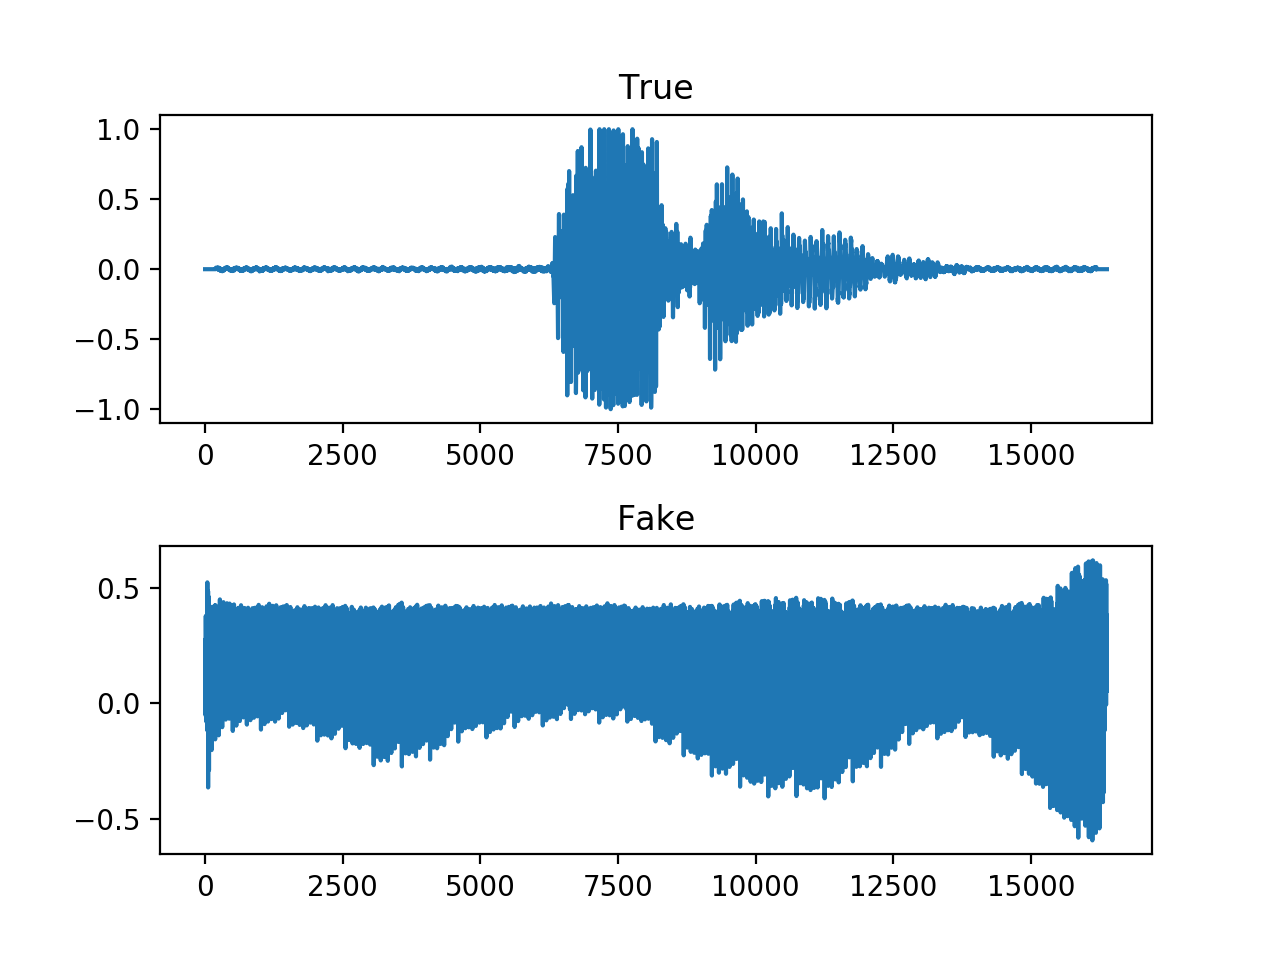

frames_it11000.png successfully saved to results


<IPython.core.display.Javascript object>


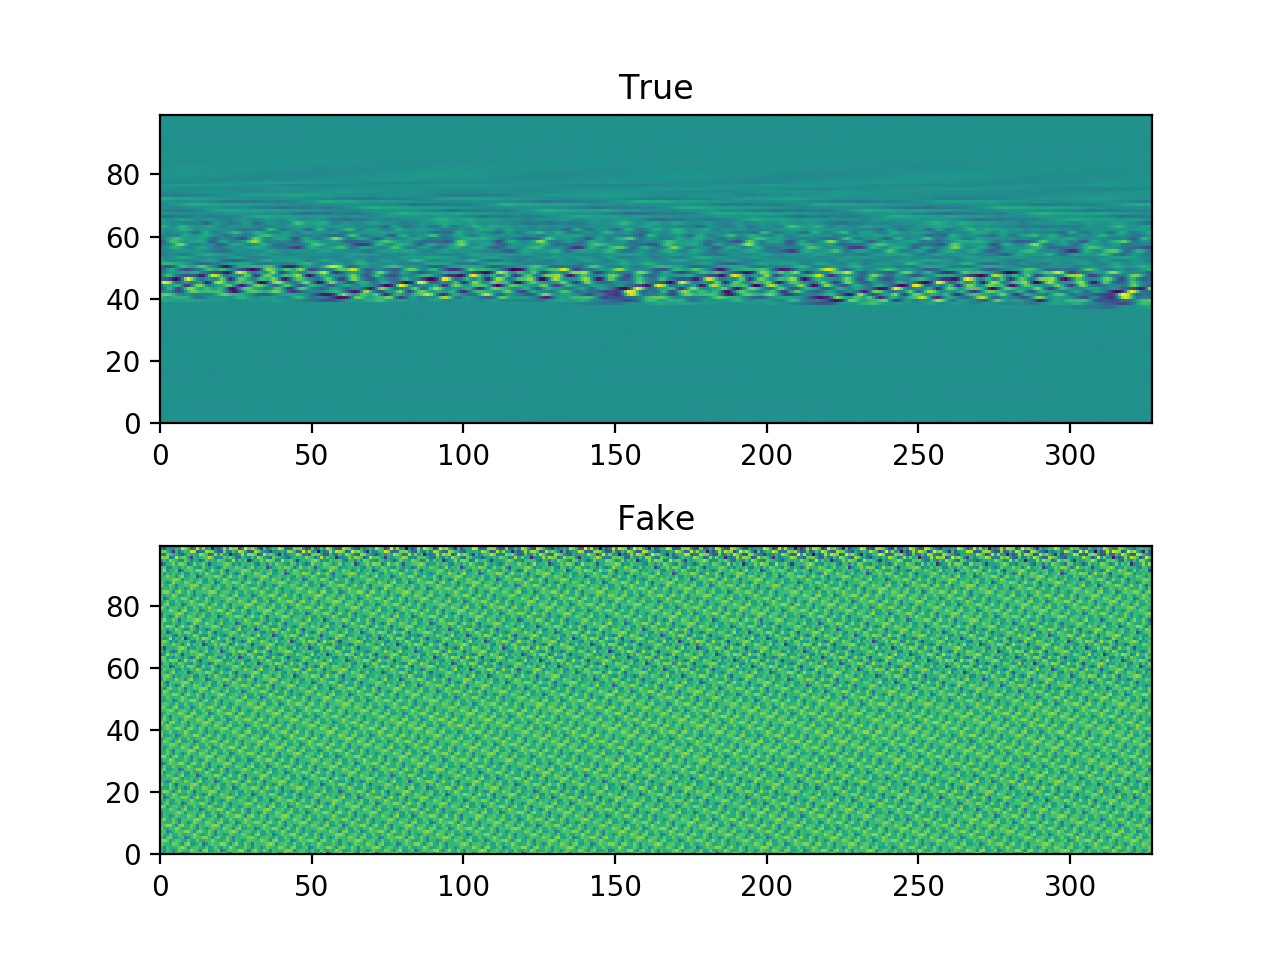

pre-emph_it11000.png successfully saved to results


<IPython.core.display.Javascript object>


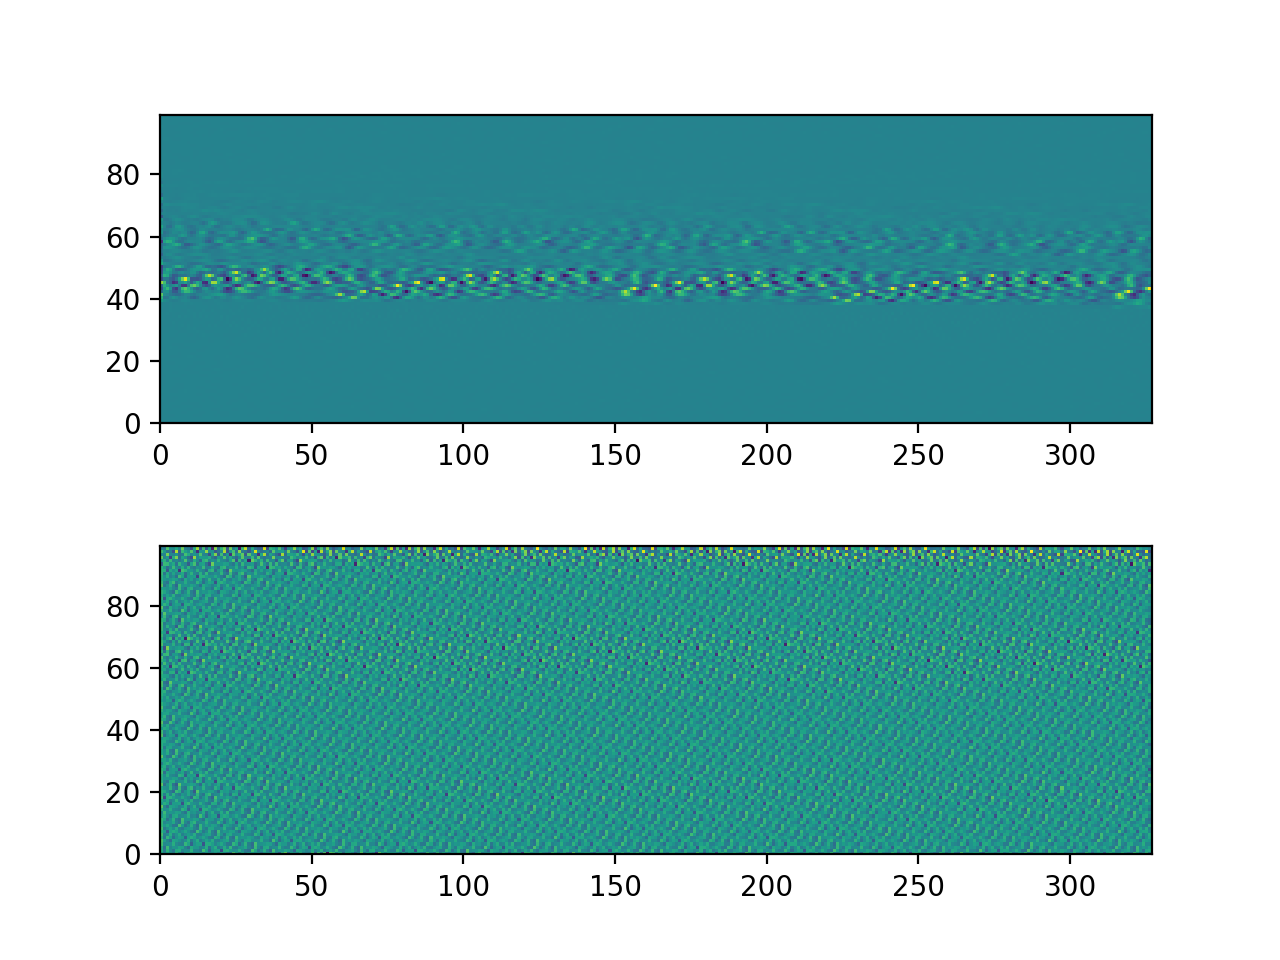

window_it11000.png successfully saved to results


<IPython.core.display.Javascript object>


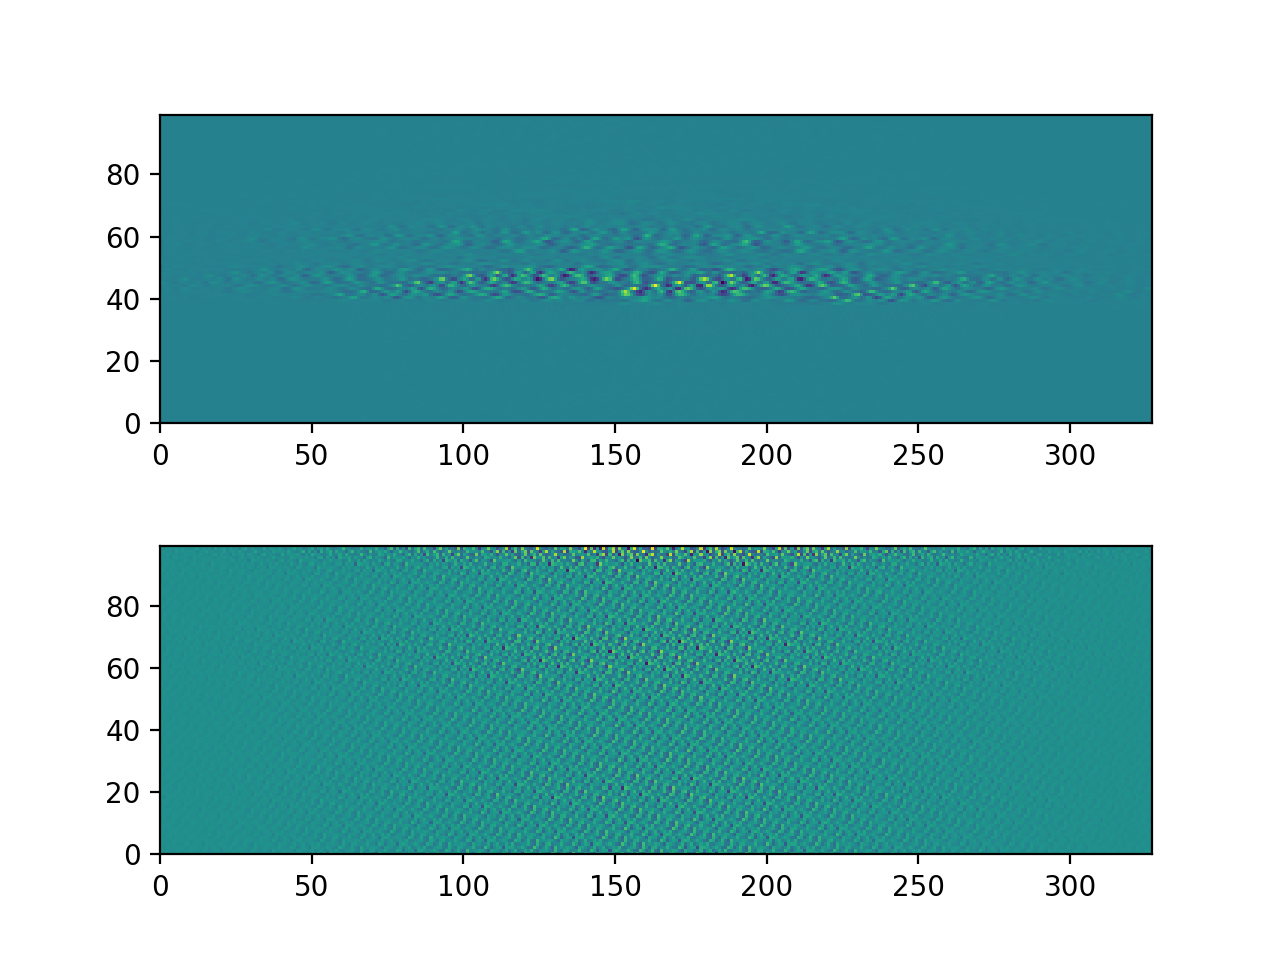

spectrogram_it11000.png successfully saved to results


<IPython.core.display.Javascript object>


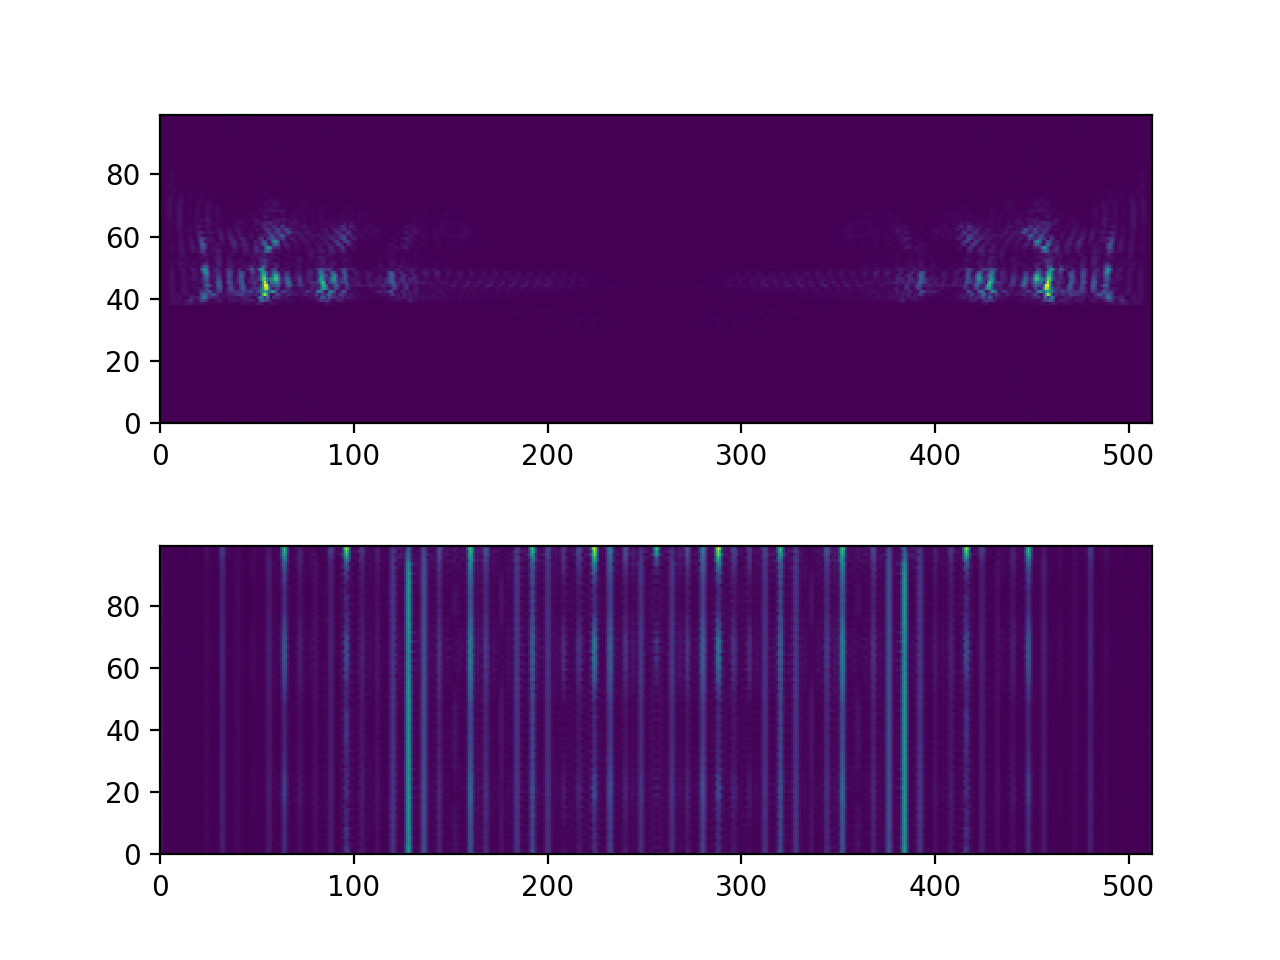

In [13]:
# define the number of random samples
rand_samples = 5
fs = 16384
input_dim = 100
pretrained_model = "Full_Model_it11000"
graph = tf.Graph()
with graph.as_default():
    config = tf.ConfigProto(allow_soft_placement = True)
    config.gpu_options.allow_growth = True
    with tf.Session(config=config, graph=graph) as sess: 
        # import metagraph
        save_path = get_checkpoint_path(pretrained_model)
        Generator_loader = tf.train.import_meta_graph(save_path + '.meta')
        # select input/output tensor
        Generator_INTPUT = graph.get_tensor_by_name('Fake_Signal:0')
        Generator_OUTPUT = graph.get_tensor_by_name('Generator/Generator_OUTPUT:0')
        is_training_ops = graph.get_tensor_by_name('is_training:0')
        # initialize vars and restore
        sess.run(tf.global_variables_initializer())
        Generator_loader.restore(sess, save_path)
        
        for i in range(rand_samples):
            Fake_Signal = np.random.uniform(low=-1.0, high=1.0, size=Generator_INTPUT.get_shape().as_list())
            fed_dict = {
                Generator_INTPUT: Fake_Signal,
                is_training_ops: False
            }
            out = sess.run(Generator_OUTPUT, feed_dict=fed_dict)
#             out = sess.run(float_to_int16(out))
            fake_music = out[np.random.randint(Generator_INTPUT.get_shape().as_list()[0])]
            sd.play(fake_music, fs)
            music_path = get_results_path("fake_music_{}.wav".format(i))
            wavf.write(music_path, fs, fake_music)
            
tf.reset_default_graph()
sess.close()

# vizualise results
plt.ioff()
# 4.1 - Create a two dimensional array where each row is a frame of samples.
k_sample = 1
ref_path = get_par_results_path("true_sample{}.wav".format(k_sample))
_, true_example = wavf.read(ref_path)
fake_example = fake_music.flatten()
vizualise_samples(fake_example,true_example, itr=11000, fs=fs)